In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from os import listdir, getcwd, chdir
from os.path import isfile, join
from diff_predictor import data_process

In [2]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks/demo_notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks


Define path to the data, and generate a filelist for the desired csv's

In [3]:
data_path = '../diff_predictor/tests/testing_data/'
filelist = [f for f in listdir(data_path) if isfile(join(data_path, f)) and 'feat' in f]
len(filelist) #Check to make sure there are the right number of files, in this case 15 - five per class

15

Next, we makea list of features we want to include in the PCA analysis. Mean features are based on a local average of surrounding trajectories for each trajectory

In [4]:
feature_list = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

Here, we create a dataframe (fstats_tot) that is the data from all the individual CSV's, so we can work with one dataframe instead of 15 individual
 files

In [5]:
fstats_tot = data_process.generate_fullstats(data_path, filelist, ['P14','P35', 'P70'], 'age')

Adding file features_P14_40nm_s1_v5.csv size: (268, 91)
Adding file features_P70_40nm_s1_v5.csv size: (17, 67)
Adding file features_P70_40nm_s1_v4.csv size: (21, 67)
Adding file features_P14_40nm_s1_v4.csv size: (140, 91)
Adding file features_P70_40nm_s1_v1.csv size: (27, 67)
Adding file features_P14_40nm_s1_v1.csv size: (793, 91)
Adding file features_P14_40nm_s1_v3.csv size: (519, 91)
Adding file features_P70_40nm_s1_v3.csv size: (25, 67)
Adding file features_P35_brain_2_slice_1_vid_1.csv size: (416, 23)
Adding file features_P70_40nm_s1_v2.csv size: (12, 67)
Adding file features_P14_40nm_s1_v2.csv size: (1356, 91)


In [6]:
ecm = fstats_tot[feature_list + ['age']]
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm = ecm.fillna(0) #setting any Deff2 values that are NA to 0
ecm.shape

(2382, 33)

In [7]:
labels = np.array(ecm['age'])
features_df = ecm.drop(['age'], axis=1) #We dont want the target column in the data that undergoes PCA
#col_names = features_df.columns

The feature data needs to be scaled prior to PCA. We can do this using scikit-learn's built in scaling functions

In [8]:
scaler = StandardScaler() #creater the standard scaler object
scaled_df = scaler.fit_transform(features_df) # Scale the feature data
scaled_df = pd.DataFrame(scaled_df, columns=feature_list) # the fit function returns an array, so we can convert it back to a dataframe

Now, we can use scikit-learn's PCA function to fit our data

In [9]:
pca = PCA(n_components=10).fit(scaled_df) # Reduce the number of features down to 10 columns - this number is variable
print(pca.explained_variance_ratio_.sum()) # This prints what percentage of the variance is captured by the n_components

0.8361079632643417


In [10]:
pca_embeddings = pca.transform(scaled_df)
pca_embeddings_df = pd.DataFrame(pca_embeddings[:, :2], columns=['Component 1', 'Component 2'])
pca_embeddings_df['target'] = labels

P14
P70


Text(0.5, 1.0, 'First and Second Principal Components of Age Dataset')

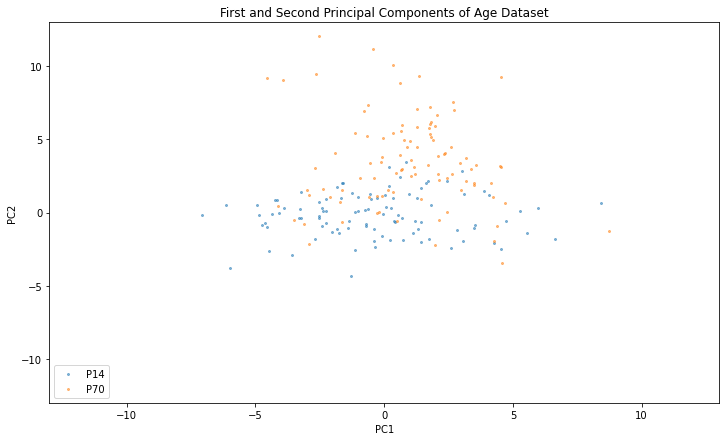

In [17]:
fig = plt.figure(figsize=(12,7))
for unique_class in pca_embeddings_df['target'].unique():
    print(unique_class)
    df = pca_embeddings_df[pca_embeddings_df['target'] == unique_class].sample(100) # We plot less points to make a cleaner figure
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.5, s=4, label=unique_class)#, c=colors[unique_class])
plt.legend(loc='lower left')
plt.xlim([-13,13])
plt.ylim([-13,13])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First and Second Principal Components of Age Dataset')
    